**Table of contents**<a id='toc0_'></a>    
- [Notes](#toc1_)    
  - [To do](#toc1_1_)    
- [Package instalation](#toc2_)    
- [Test No data frame single likelihood](#toc3_)    
- [Test without data frame & with multiple likelihood](#toc4_)    
- [Test with data frame in likelihood](#toc5_)    
- [Indices](#toc6_)    
- [Model comparaison](#toc7_)    
- [Multiple indices](#toc8_)    
- [ Categorical interactions](#toc9_)    
- [ Continuous interactions](#toc10_)    
- [Binomial model](#toc11_)    
- [Binomial with index](#toc12_)    
- [Poisson](#toc13_)    
- [This doesn't work](#toc14_)    
- [Negative binomial](#toc15_)    
- [Multinomial](#toc16_)    
  - [Categorical models](#toc16_1_)    
  - [Multinomial in disguise as Poisson](#toc16_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Notes](#toc0_)

- Gpu computation is not always better, it depends of your model size: https://stackoverflow.com/questions/55749899/training-a-simple-model-in-tensorflow-gpu-slower-than-cpu

- Depending on the float precision model outputs may differ.


## <a id='toc1_1_'></a>[To do](#toc0_)
    1.  Allow mathematical operation within formula
    2.  Redo GUI
    3.  Help functions
    4.  Documentation
    5.  Multinomial models to be run with Multinomial distribution
    6.  Multiple likelihoods can have different types: independent models -> independent HMC, dependent priors -> 
    7.  single HMC which need to be evaluated by looking at all mais infos.
    8.  Priors can have args and kwargs

Current WIP BetaBinomial, require to handle multiple likelihoods

# <a id='toc2_'></a>[Package instalation](#toc0_)

In [ ]:
try:
  %pip install tensorflow tensorflow_probability pandas numpy arviz seaborn functools matplotlib.pyplot
  %pip install git+https://github.com/BGN-for-ASNA/BI.git
except:
  pass

# <a id='toc3_'></a>[Test No data frame single likelihood](#toc0_)

In [116]:
from  main import *
formula = dict(main = 'y~Normal(m,s)',
            likelihood = 'm ~  alpha + beta',
            prior1 = 's~Exponential(1)',
            prior2 = 'alpha ~ Normal(0,1)',
            prior3 = 'beta ~ Normal(0,1)')  
self = model(formula= formula, float = 16) 
self.sample()
self.tensor_dict

{'s': <tfp.distributions.Sample 'Sampleprior1' batch_shape=[] event_shape=[1] dtype=float16>,
 'alpha': <tfp.distributions.Sample 'Sampleprior2' batch_shape=[] event_shape=[1] dtype=float16>,
 'beta': <tfp.distributions.Sample 'Sampleprior3' batch_shape=[] event_shape=[1] dtype=float16>,
 'y': <function <lambda>(s, alpha, beta)>}

In [119]:
self.main_text

{'y': 'lambda s, alpha, beta: tfd.Independent(tfd.Normal(alpha+beta,s,), reinterpreted_batch_ndims=1)'}

# <a id='toc4_'></a>[Test without data frame & with multiple likelihood](#toc0_)

In [5]:
from  main import *
formula = dict(main = 'y~Normal(m,s)',
            likelihood = 'm ~  alpha + beta',
            prior1 = 's~Exponential(1)',
            prior2 = 'alpha ~ Normal(0,1)',
            prior3 = 'beta ~ Normal(0,1)',
            
            main1 = 'z~Normal(m2,s2)',
            likelihood2 = 'm2 ~ alpha2 + beta2',
            prior4 = 's2~Exponential(1)',
            prior5 = 'alpha2 ~ Normal(0,1)',
            prior6 = 'beta2 ~ Normal(0,1)') 
self = model(formula= formula, float = 16)
self.log_prob(self.sample(10))

2024-02-08 14:06:21.264485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 14:06:21.264546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 14:06:21.264564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 14:06:21.264794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 14:06:21.264808: I tensorflow/core/common_runtime/gpu/gpu

<tf.Tensor: shape=(10,), dtype=float16, numpy=
array([-10.31 , -18.36 ,  -5.246, -12.984, -11.24 , -10.94 , -15.7  ,
        -3.686, -19.   ,  -8.336], dtype=float16)>

# <a id='toc5_'></a>[Test with data frame in likelihood](#toc0_)

In [2]:
from  main import *
## Model m4.3
d = pd.read_csv('./data/Howell1.csv', sep=';')
d = d[d.age > 18]
#self.df["weight.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d.weight = d.weight - d.weight.mean()
d.age = d.age - d.age.mean()
formula = dict(main1 = 'height ~ Normal(mu,sigma)',
            likelihood = 'mu ~ alpha + beta * weight',
            prior1 = 'sigma ~ Uniform(0,50)',
            prior2 = 'alpha ~ Normal(178,20)',
            prior3 = 'beta ~ Normal(0,1)')    

self = model(formula, df = d, float = 32)
print('tensor DICT:')
print(self.tensor_dict)
print('tensor likelihoods:')
print(self.main_text)
self.fit(observed_data = dict(height =d.height.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
self.summary()

# expected 
#           Mean    StdDev  5.5%    94.5%   a   b   sigma
#   a       154.60  0.27    154.17  155.03  1   0   0
#   b       0.91    0.04    0.84    0.97    0   1   0
#   sigma   5.07    0.19    4.77    5.38    0   0   1

2024-02-08 09:53:58.314636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:53:58.314702: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:53:58.314716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:53:58.314935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:53:58.314948: I tensorflow/core/common_runtime/gpu/gpu

tensor DICT:
{'sigma': <tfp.distributions.Sample 'SampleUniform' batch_shape=[] event_shape=[1] dtype=float32>, 'alpha': <tfp.distributions.Sample 'SampleNormal' batch_shape=[] event_shape=[1] dtype=float32>, 'beta': <tfp.distributions.Sample 'SampleNormal' batch_shape=[] event_shape=[1] dtype=float32>, 'height': <function <lambda> at 0x7fdd91a78ee0>}
tensor likelihoods:
{'height': 'lambda sigma, alpha, beta: tfd.Independent(tfd.Normal(alpha+beta*df.weight.values,sigma,), reinterpreted_batch_ndims=1)'}


,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],5.15,0.20,4.84,5.47
beta[0],0.90,0.04,0.84,0.98
alpha[0],154.64,0.28,154.19,155.08


# <a id='toc6_'></a>[Indices](#toc0_)

In [3]:
## Model m5.9 
from  main import *
self = model()
self.import_csv('./data/milk.csv', sep = ';')
self.df["K"] = self.df["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
self.index(cols = "clade")

formula = dict(main = 'K ~ Normal(mu,sigma)',
            likelihood = 'mu ~ alpha[index_clade]',
            prior1 = 'alpha~ Normal(0,0.5)',
            prior2 = 'sigma ~ Exponential(1)') 

self.formula(f = formula)
self.build_model()
self.fit(observed_data = dict(K =self.df.K.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
self.summary()

# Expected:
#                mean	sd	    hdi_5.5%	hdi_94.5%
# ape_alpha	    -0.48	0.27	-0.93	    -0.08
# nwm_alpha	    0.37	0.22	0.03	    0.73
# owm_alpha	    0.65	0.30	0.26	    1.18
# strep_alpha	-0.55	0.29	-1.07	    -0.19
# sigma	        0.83	0.13	0.67	    1.06

2024-02-08 09:54:03.932373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:03.932424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:03.932438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:03.932568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:03.932574: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.80,0.12,0.61,0.97
alpha[0],-0.47,0.25,-0.88,-0.08
alpha[1],0.35,0.24,-0.03,0.72
alpha[2],0.64,0.28,0.19,1.08
alpha[3],-0.55,0.30,-1.03,-0.08


# <a id='toc7_'></a>[Model comparaison](#toc0_)

In [4]:
from  main import*
# m8.1
m = model()
d = pd.read_csv('./data/rugged.csv', sep = ';')
# make log version of outcome
d['log_gdp'] = np.log(d.rgdppc_2000)
# extract countries with GDP data

# rescale variables
d['log_gdp_std'] = d["log_gdp"].pipe(lambda x: (x / x.mean()) )
d['rugged_std'] = d["rugged"].pipe(lambda x: (x / x.max()) )
d['rugged_std'] - 0.215
d = d.loc[:,['rugged_std','log_gdp_std', 'cont_africa','log_gdp']]
d = d.dropna()
formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a + b* rugged_std ',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_1 = model(formula, d)

m8_1.fit(observed_data = dict(log_gdp_std =d.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_1.summary()

#Expected:
#       mean    sd      5.5%    94.5%
#a      1.00    0.01    0.98    1.0
#b      0.00    0.05    -0.09   0.09
#sigma  0.14    0.01    0.12    0.15


2024-02-08 09:54:08.616063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:08.616120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:08.616136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:08.616343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:08.616354: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.14,0.01,0.13,0.15
b[0],0.00,0.07,-0.11,0.11
a[0],1.00,0.02,0.97,1.02


In [5]:

d = pd.read_csv('./data/rugged.csv', sep = ';')
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)
dd["cid"]

formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a[cid] + b*rugged_std',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_2= model(formula, dd)
m8_2.fit(observed_data = dict(log_gdp_std =dd.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_2.summary()

#Expected:
#       mean    sd      5.5%    94.5%
#a[1]   0.88    0.02    0.85    0.91
#a[2]   1.05    0.01    1.03    1.07
#b      -0.05   0.05    -0.12   0.03
#sigma  0.11    0.01    0.10    0.1


2024-02-08 09:54:13.897196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:13.897263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:13.897277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:13.897489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:13.897501: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.11,0.01,0.10,0.12
b[0],-0.05,0.05,-0.12,0.03
a[0],0.89,0.02,0.86,0.92
a[1],1.06,0.01,1.04,1.08


In [6]:
m8_2.diag_compare({'m8.1': m8_1.trace, 'm8.2': m8_2.trace})
#       rank	elpd_loo	p_loo	    elpd_diff	weight	se	    dse	    warning	    scale
#m8.2	0	    128.021790	3.008224	0.000000	1.0	    0.0	    0.0	    True	    log
#m8.1	1	    95.414886	2.317650	32.606903	0.0	    0.0	    0.0	    True	    log

/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:839: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well i

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m8.2,0,127.699005,3.376434,0.000000,1.000000e+00,0.0,0.0,True,log
m8.1,1,95.523918,2.223770,32.175087,2.220446e-16,0.0,0.0,True,log


# <a id='toc8_'></a>[Multiple indices](#toc0_)

In [7]:
# m8.3
from main import*
d = pd.read_csv('./data/rugged.csv', sep = ';')
d["log_gdp"] = d["rgdppc_2000"].pipe(np.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)
dd["cid"]


formula = dict(
    main = 'log_gdp_std ~ Normal( mu , sigma ) ',
    likelihood = 'mu ~ a[cid] + b[cid]*rugged_std',
    prior1 = 'a ~ Normal( 1 , 0.1  )' ,
    prior2 = 'b ~ Normal( 0 , 0.3 )' ,
    prior3 = 'sigma ~ Exponential( 1 )'
)

m8_3= model(formula, dd)
m8_3.fit(observed_data = dict(log_gdp_std =dd.log_gdp_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_3.summary()

# Expected:
#       mean    sd      5.5%    94.5%
#a[1]   0.89    0.02    0.86    0.91
#a[2]   1.05    0.01    1.03    1.07
#b[1]   0.13    0.07    0.01    0.25
#b[2]   -0.14   0.05    -0.23    -0.06
#sigma  0.11    0.01    0.10    0.12

2024-02-08 09:54:19.462057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:19.462127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:19.462140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:19.462329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:19.462341: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.11,0.01,0.10,0.12
b[0],0.10,0.08,-0.02,0.23
b[1],-0.14,0.05,-0.22,-0.05
a[0],0.86,0.02,0.83,0.90
a[1],1.08,0.02,1.05,1.10


# <a id='toc9_'></a>[ Categorical interactions](#toc0_)

In [8]:
d = pd.read_csv('./data/tulips.csv', sep = ';')
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

formula = dict(
            main = 'blooms_std ~ Normal( mu , sigma ) ',
            likelihood ='mu ~ a + bw*water_cent + bs*shade_cent' ,
            prior1 = 'a ~ Normal( 0.5 , 0.25 ) ',
            prior2 = 'bw ~ Normal( 0 , 0.25 ) ',
            prior3 = 'bs ~ Normal( 0 , 0.25 ) ',
            prior4 = 'sigma ~ Exponential( 1 )',
            )
m8_4 = model(formula, d)
m8_4.fit(observed_data = dict(blooms_std =d.blooms_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_4.summary()
#Expected:
#       mean   sd       5.5%    94.5%
#a      0.36    0.03     0.31    0.41
#bw     0.21    0.04     0.15    0.26
#bs    -0.11    0.04    -0.17   -0.05
#sigma  0.16    0.02     0.12    0.19

2024-02-08 09:54:25.026062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:25.026115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:25.026129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:25.026306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:25.026319: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.18,0.03,0.14,0.22
bw[0],0.20,0.04,0.14,0.27
bs[0],-0.11,0.04,-0.18,-0.05
a[0],0.36,0.03,0.31,0.41


# <a id='toc10_'></a>[ Continuous interactions](#toc0_)

In [9]:
## Model m8.3
d = pd.read_csv('./data/tulips.csv', sep = ';')
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

formula = dict(
            main = 'blooms_std ~ Normal( mu , sigma ) ',
            likelihood ='mu ~ a + bw*water_cent + bs*shade_cent + bws*water_cent*shade_cent' ,
            prior1 = 'a ~ Normal( 0.5 , 0.25 ) ',
            prior2 = 'bw ~ Normal( 0 , 0.25 ) ',
            prior3 = 'bs ~ Normal( 0 , 0.25 ) ',
            prior4 = 'bws ~ Normal( 0 , 0.25 ) ',
            prior5 = 'sigma ~ Exponential( 1 )',
            )
m8_5 = model(formula, d)
m8_5.fit(observed_data = dict(blooms_std =d.blooms_std.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m8_5.summary()

# Expected
#       mean   sd  5.5% 94.5%
#a      0.36 0.02  0.32  0.40
#bw     0.21 0.03  0.16  0.25
#bs    -0.11 0.03 -0.16 -0.07
#bws   -0.14 0.04 -0.20 -0.09
#sigma  0.12 0.02  0.10  0.15

2024-02-08 09:54:31.810754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:31.810808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:31.810821: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:31.810975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:31.810981: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
sigma[0],0.14,0.02,0.11,0.18
bws[0],-0.14,0.04,-0.20,-0.08
bw[0],0.21,0.03,0.15,0.26
bs[0],-0.11,0.03,-0.17,-0.06
a[0],0.36,0.03,0.31,0.40


# <a id='toc11_'></a>[Binomial model](#toc0_)

In [1]:
from main import*
d = pd.read_csv('./data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

d_aggregated = (
    d.groupby(["treatment", "actor", "side", "cond"])["pulled_left"].sum().reset_index()
)
d_aggregated.rename(columns={"pulled_left": "left_pulls"}, inplace=True)
d_aggregated["actor_id"] = d_aggregated["actor"].values - 1

formula = dict(
    main = 'pulled_left ~ Binomial( 1 , logits = p )' ,
    likelihood = 'p ~ a' ,
    prior1 = 'a ~ Normal( 0 , 10 )'
)

m11_1 = model(formula, d)
m11_1.fit(observed_data = dict(pulled_left =d.pulled_left.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_1.summary()


# expected
#  mean   sd 5.5% 94.5%
#a 0.32 0.09 0.18  0.46

2024-02-08 14:31:57.352279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 14:31:57.517523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 14:31:57.517551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 14:31:57.543623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 14:31:57.598778: I tensorflow/core/platform/cpu_feature_guar

[<tf.Tensor 'JointDistributionNamed/sample/Sampleprior1/sample/Reshape:0' shape=(4, 1) dtype=float32>]
SimpleStepSizeAdaptationResults(
  inner_results=TransformedTransitionKernelResults(
      transformed_state=[<tf.Tensor 'JointDistributionNamed/sample/Sampleprior1/sample/Reshape:0' shape=(4, 1) dtype=float32>],
      inner_results=MetropolisHastingsKernelResults(
          accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
              log_acceptance_correction=<tf.Tensor 'mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/zeros_like:0' shape=(4,) dtype=float32>,
              target_log_prob=<tf.Tensor 'mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/add_1:0' shape=(4,) dtype=float32>,


,mean,sd,hdi_5.5%,hdi_94.5%
a[0],0.32,0.09,0.18,0.47


# <a id='toc12_'></a>[Binomial with index](#toc0_)

In [11]:
from main import*
d = pd.read_csv('./data/chimpanzees.csv', sep = ';')
d.actor = d.actor - 1
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]


formula = dict(
    main = 'pulled_left ~ Binomial(1 , p )' ,
    likelihood = 'p ~ a[actor] + b[treatment]' ,
    prior1 = 'a ~ Normal(0,1.5)',
    prior2 = 'b ~ Normal(0,0.5)'
)
m11_4 = model(formula, d, float = 32)
m11_4.fit(observed_data = dict(pulled_left =d.pulled_left.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_4.summary()
# Expected
#          mean    sd   5.5%    94.5%   n_eff Rhat
#a[1]   -0.45    0.32   -0.95    0.04   690 1
#a[2]   3.86     0.73   2.78     5.09   1417 1
#a[3]   -0.75    0.33   -1.28    -0.23   765 1
#a[4]   -0.74    0.33   -1.26    -0.21   887 1
#a[5]   -0.44    0.32   -0.94    0.10   743 1
#a[6]   0.48     0.32   -0.02    1.00   894 1
#a[7]   1.95     0.40   1.32    2.63    882 1
#b[1]   -0.04    0.28   -0.51    0.40   669 1
#b[2]   0.48     0.28   0.04    0.92    675 1
#b[3]   -0.38    0.28   -0.83    0.06    768 1
#b[4]   0.37     0.27   -0.07    0.79   666 1


2024-02-08 09:54:44.395553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:44.395623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:44.395639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:44.395855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:54:44.395867: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
b[0],-0.04,0.29,-0.48,0.45
b[1],0.48,0.29,0.03,0.95
b[2],-0.40,0.28,-0.82,0.07
b[3],0.38,0.29,-0.08,0.83
a[0],-0.46,0.33,-1.00,0.04
a[1],3.89,0.75,2.71,5.06
a[2],-0.75,0.33,-1.29,-0.24
a[3],-0.75,0.33,-1.28,-0.21
a[4],-0.46,0.34,-1.00,0.06
a[5],0.47,0.33,-0.04,1.03


array([<Axes: >, <Axes: title={'center': 'ess'}>], dtype=object)

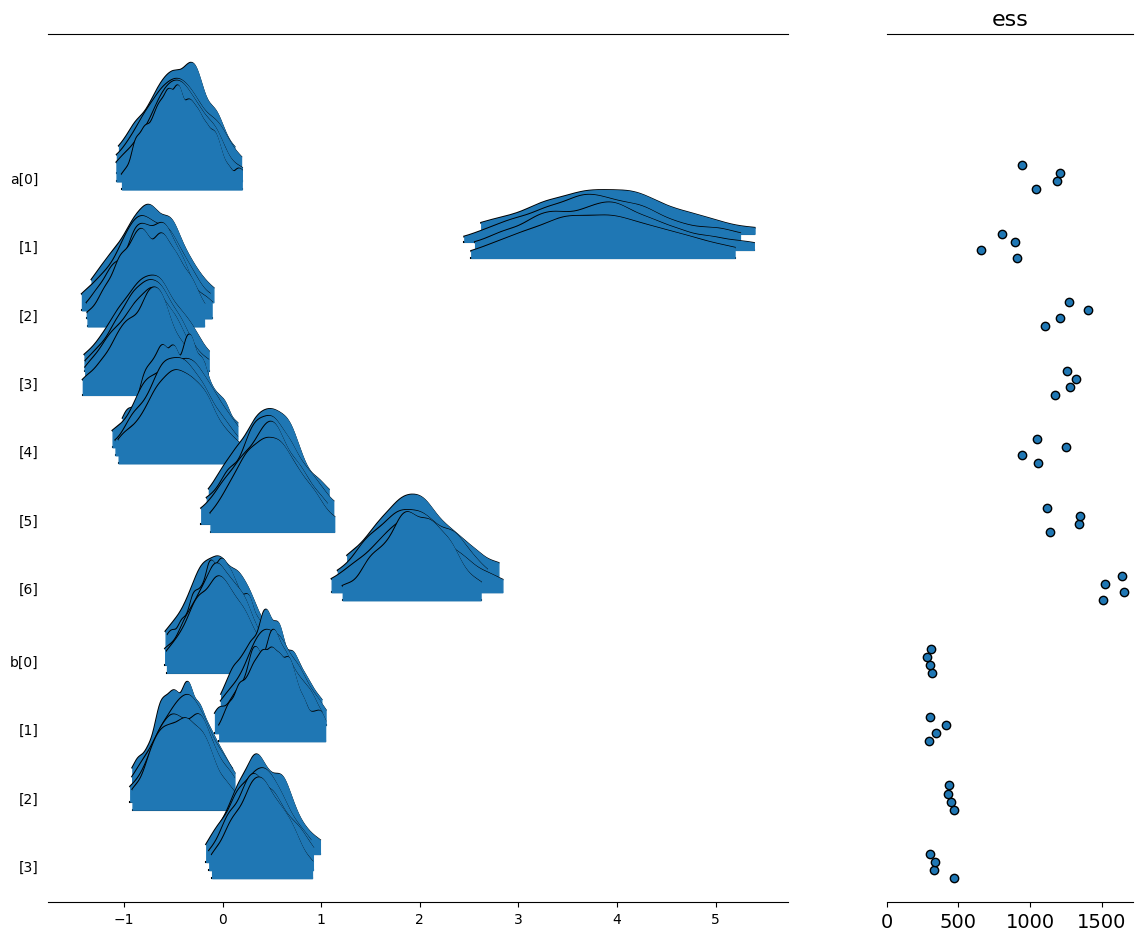

In [12]:
m11_4.diag_forest()

# <a id='toc13_'></a>[Poisson](#toc0_)

In [26]:
from main import*
d = pd.read_csv('./data/Kline.csv', sep = ';')
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)
d['pLog'] = tf.math.log(d.P).numpy()
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha',
               prior1 = 'alpha ~ Normal(3,0.5)')
m11_9 = model(formula, d)
m11_9.fit(observed_data = dict(total_tools =d.total_tools.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_9.summary()
#Expected
#  mean   sd 5.5% 94.5% rhat ess_bulk
#a 3.54 0.05 3.46  3.63 1.01   679.05

2024-02-08 10:04:25.441451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:25.441512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:25.441526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:25.441684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:25.441695: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],3.54,0.05,3.45,3.62


In [27]:
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha[cid] + beta[cid]*P',
               prior1 = 'alpha ~ Normal(3,0.5)',
               prior2 = 'beta ~ Normal(0,0.2)')
m11_10 = model(formula, d)
m11_10.fit(observed_data = dict(total_tools =d.total_tools.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_10.summary()
# Expected
#     mean   sd     5.5%    94.5% rhat ess_bulk
#a[1] 3.32  0.09     3.19   3.46    1  1553.42
#a[2] 3.61  0.07     3.49   3.73    1  2004.06
#b[1] 0.38  0.05     0.29   0.46    1  1769.96
#b[2] 0.18  0.16    -0.07   0.45    1  1747.86

2024-02-08 10:04:30.966723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:30.966779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:30.966792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:30.966968: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 10:04:30.966982: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
beta[0],0.38,0.05,0.29,0.46
beta[1],0.19,0.16,-0.08,0.43
alpha[0],3.32,0.09,3.18,3.45
alpha[1],3.61,0.07,3.48,3.72


In [28]:
m11_9.diag_compare({'m11_9': m11_9.trace, 'm11_10': m11_10.trace})

/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:839: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/home/sosa/.local/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well i

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11_10,0,-42.841156,2.865967,0.000000,1.0,0.0,0.0,True,log
m11_9,1,-67.775467,0.890450,24.934311,0.0,0.0,0.0,True,log


# <a id='toc14_'></a>[This doesn't work due to 'P^' -> need to implement mathematical operation within formulas](#toc0_)

In [16]:
from main import*
d = pd.read_csv('./data/Kline.csv', sep = ';')
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)
d['pLog'] = tf.math.log(d.P).numpy()
formula = dict(main = 'total_tools ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ alpha[cid] +  P^beta[cid]',
               prior1 = 'alpha ~ Normal(3.,0.5)',
               prior2 = 'beta ~ Normal(0,0.2)')
m11_11 = model(formula, d)
m11_11.tensor_dict

{'alpha': <tfp.distributions.Sample 'SampleNormal' batch_shape=[] event_shape=[2] dtype=float32>,
 'beta': <tfp.distributions.Sample 'SampleNormal' batch_shape=[] event_shape=[2] dtype=float32>,
 'total_tools': <function <lambda>(alpha, beta)>}

2024-02-08 09:55:03.485895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:55:03.485977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:55:03.485997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:55:03.486113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 09:55:03.486120: I tensorflow/core/common_runtime/gpu/gpu

# <a id='toc15_'></a>[Negative binomial](#toc0_)

In [1]:
from main import*
num_days = 30
y = tfd.Poisson(rate=1.5).sample((num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample((num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)
# Select columns with 'float64' dtype  
float64_cols = list(d.select_dtypes(include='float64'))

# The same code again calling the columns
d[float64_cols] = d[float64_cols].astype('float32')


formula = dict(main = 'y ~ Poisson(log_rate = lambda)',
               likelihood = 'lambda ~ log_days + alpha +  beta * monastery',
               prior1 = 'alpha ~ Normal(0,1)',
               prior2 = 'beta ~ Normal(0,1)')
m11_12 = model(formula, d, float=32)
m11_12.fit(observed_data = dict(y =d.y.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_12.summary()
# Expected
#   mean    sd      5.5%    94.5%
#a  0.37    0.15     0.13    0.61
#b -1.13    0.30    -1.61   -0.65

2024-02-08 10:06:02.909196: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 10:06:02.929491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 10:06:02.929510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 10:06:02.930082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 10:06:02.933837: I tensorflow/core/platform/cpu_feature_guar

,mean,sd,hdi_5.5%,hdi_94.5%
beta[0],-1.23,0.31,-1.73,-0.73
alpha[0],0.36,0.15,0.13,0.59


# <a id='toc16_'></a>[Multinomial](#toc0_)

## <a id='toc16_1_'></a>[Categorical models](#toc0_)

In [10]:
from main import*
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = tf.nn.softmax(score)

# now simulate choice
# outcome career holds event type values, not counts
career = np.repeat(np.nan, N)  # empty vector of choices for each individual

# sample chosen career for each individual
for i in range(N):
    career[i] = tfd.Categorical(probs=p).sample()

career = career.astype(int)
result = [income[index] for index in career]
data = {'career': career, 'income': result}
df = pd.DataFrame(data)
df

,career,income
0,2,5
1,1,2
2,2,5
3,2,5
4,2,5
...,...,...
495,2,5
496,1,2
497,2,5
498,2,5


How to programatically determine this model?

In [28]:
def test(N, K = 3, formula = 'alpha + beta*income'):
    def _generator():
        alpha = yield tfd.Sample(tfd.Normal(0,1), sample_shape = (K - 1))
        beta = yield tfd.Sample(tfd.Normal(0,1), sample_shape = 1)
        Class1 =  tf.gather(alpha, [0], axis=-1) + beta * income[0]
        Class2 =  tf.gather(alpha, [1], axis=-1) + beta *income[1]
        Class3 = tf.zeros_like(Class1)  # pivot
        stack = tf.stack([Class1, Class2, Class3], axis=1)
        p =  tf.nn.softmax(stack)
        career =  yield tfd.Independent(tfd.Categorical(probs = p), reinterpreted_batch_ndims=1)
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)

## Multinomial in disguise as Binomial

In [1]:
from main import*
d = pd.read_csv('./data/UCBadmit.csv', sep = ';')

formula = dict(main = "y ~ Binomial(applications, logits = lambda)",
               likelihood = 'lambda ~ alpha',
               prior1 = 'alpha ~ Normal(0.,1.5)')
m11_14 = model(formula, d, float=32)

m11_14.fit(observed_data = dict(y =d.admit.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
m11_14.summary()

2024-02-09 13:15:26.978171: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 13:15:26.998505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 13:15:26.998526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 13:15:26.999035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 13:15:27.003330: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_compile is deprecated, use jit_compile instead


2024-02-09 13:15:28.485028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 13:15:28.507226: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 13:15:28.507261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 13:15:28.509858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 13:15:28.509891: I external/local_xla/xla/stream_executor

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],-0.46,0.03,-0.51,-0.41


In [4]:
m11_14.invt_logit(np.mean(m11_14.posterior['alpha']))

0.38772363780375135

## <a id='toc16_2_'></a>[Multinomial in disguise as Poisson](#toc0_)

We can run N independent poisson models (one for each class) and compute there probability using the posteriors fo each models

In [2]:
from main import*
d = pd.read_csv('./data/UCBadmit.csv', sep = ';')
formula = dict(main = 'y ~ Poisson(log_rate=lambda1)',
               likelihood = 'lambda1 ~ alpha',
               prior1 = 'alpha ~ Normal(0.,1.5)'
               )
m11_14 = model(formula, d)
m11_14.fit(observed_data = dict(y =d.admit.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)
formula = dict(main = 'y ~ Poisson(log_rate=lambda1)',
               likelihood = 'lambda1 ~ alpha',
               prior1 = 'alpha ~ Normal(0.,1.5)'
               )
m11_14_2 = model(formula, d)
m11_14_2.fit(observed_data = dict(y =d.reject.astype('float32').values),
                                           num_results = 2000, num_burnin_steps=500, num_adaptation_steps=400, num_chains=4)

2024-02-09 11:40:46.387993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 11:40:46.388045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 11:40:46.388058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 11:40:46.388234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-09 11:40:46.388246: I tensorflow/core/common_runtime/gpu/gpu

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],4.98,0.02,4.95,5.02


In [10]:
a1 = tf.reduce_mean(m11_14.posterior["alpha"][0], 0)
a2 = tf.reduce_mean(m11_14_2.posterior["alpha"][0], 0)
tf.exp(a1) / (tf.exp(a1) + tf.exp(a2))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.38843098], dtype=float32)>

# Beta binomial

In [13]:
from main import*
d = pd.read_csv('./data/UCBadmit.csv', sep = ';')
d["gid"] = (d["applicant.gender"] != "male").astype(int)
len(d.applications)
formula = dict(main = 'y ~ BetaBinomial(12, concentration1 = pbar, concentration0 = theta)',
               likelihood = 'pbar ~ a[gid]',
               likelihood2 = 'theta ~ phi + 2.0',
               prior1 = 'a ~ Normal(0.,1.5)',
               prior2 = 'phi ~ Exponential(1)'
               )
m12_1 = model()
m12_1.f = formula
m12_1.df = d
self = m12_1
self.get_var()
self.get_priors_names()
self.get_model_type()
self.get_undeclared_params()

{'undeclared_params': ['theta', 'pbar'], 'params_in_data': ['gid']}

# Working on multiple likelihoods
## Model informations

In [43]:
def get_main_dict():
    dict = {'output': None, 
            'input': None,
            'distribution': None, 
            'params' : None,
            'priors' : None,
            'with_likelihood': None,
            'multiple_likelihoods': None,
            'with_indices' : False,
            'params_in_df': None,
            'params_not_in_df': None,
            'likelihood(s)': {}
            } 
            
    return dict

def unlist(L):
    newList = []
    for item in L:
        if isinstance(item, list):
            for i in item:
                newList.append(i)
        else:
            newList.append(item)
    return newList

def get_likelihood_dict():
    LK_dict = {}
    self.LK_dict = LK_dict
    return LK_dict

def remove_numeric_priors(characters):
     return [char for char in characters if not is_float(char)]

def is_float(char):
    try:
        float(char)
        return True
    except ValueError:
        return False
    
def get_main_info_likelihood_indices(dict):
    dict['with_indices'] = True
    dict['indices_position'] = self.find_index_position(dict['formula'])  
    dict['indices_patterns'] = self.extract_indices_patterns(dict['formula'])  
    dict['indices_prior'] = [dict['params'][i] for i in dict['indices_position']]
    dict['indices_var'] = [dict['params'][i+1] for i in dict['indices_position']]
    return dict

def get_main_info_with_likelihood(dict, LK_dict):         
        if len(dict['params']['args']) > 0:
            LK_dict = get_main_info_likelihood_args(dict, LK_dict)
        if len(dict['params']['kwargs']) > 0:
            LK_dict = get_main_info_likelihood_kwargs(dict, LK_dict)        
        return  LK_dict

def get_main_info_likelihood_kwargs(main_dict, LK_dict):
    for key in main_dict['params']['kwargs']:
        if main_dict['params']['kwargs'][key] in self.model_names.values():               
            #check if self.model_names.values() name have likelihood in it
            key_name = self.which_key_have_value(self.model_names, main_dict['params']['kwargs'][key])
            if 'prior' in key_name:
                main_dict['priors'] = self.add_entry_if_not_none(main_dict['priors'], self.model_names[key_name])

            if 'likelihood' in key_name: # Get basic information of likelihood
                name = [k for k, v in self.model_names.items() if v == main_dict['params']['kwargs'][key]] 
                name = name[0]
                LK_dict[name] = {}   
                LK_dict[name]['main_params']= {'args':[], "kwargs":{}} 
                LK_dict[name]['formula'] = self.full_model[name]['input']
                LK_dict[name]['output'] = self.full_model[name]['var'][0]
                LK_dict[name]['params'] = self.full_model[name]['var'][1].copy() 
                x = re.split(r'[~]',LK_dict[name]['formula'])[1]
                x = x.replace(" ", "")
                LK_dict[name]['main_params']['kwargs'][key] = str(x)

                # Add information to main to build LK within lambda
                main_dict['params']['kwargs'][key] = LK_dict[name]['main_params']['kwargs'][key]
                main_dict['priors'] = self.add_entry_if_not_none(main_dict['priors'], LK_dict[name]['params'].copy())

                if "[" in LK_dict[name]['formula']: 
                    main_dict['with_indices']   = True  
                    LK_dict[name] = get_main_info_likelihood_indices(LK_dict[name])

                if len(self.undeclared_params) > 1:
                    LK_dict[name]['params_in_df'] = [x for x in  LK_dict[name]['params'] if x in self.undeclared_params['params_in_data']]                          
                    LK_dict[name]['params_not_in_df'] = [x for x in  LK_dict[name]['params']  if x not in self.undeclared_params['params_in_data']]
                   
                    if len(LK_dict[name]['params_in_df']) > 0:
                        main_dict['params_in_df'] = self.add_entry_if_not_none(main_dict['params_in_df'], LK_dict[name]['params_in_df'])
                    main_dict['params_not_in_df'] = self.add_entry_if_not_none(main_dict['params_not_in_df'], LK_dict[name]['params_not_in_df'])
                
                else:
                    LK_dict[name]['params_in_df'] = False
                    main_dict['params_in_df'] = {}
                    main_dict['params_in_df'] = False

    #main_dict['likelihood(s)'].update(LK_dict)
    return LK_dict

def get_main_info_likelihood_args(main_dict, LK_dict):
    # Find likelihood associated to this main
    for a in range(len(main_dict['params']['args'])):
        if main_dict['params']['args'][a] in self.model_names.values():
            #check if self.model_names.values() name have likelihhod in it
            key_name = self.which_key_have_value(self.model_names, main_dict['params']['args'][a])
            if 'prior' in key_name:
                main_dict['priors'] = self.add_entry_if_not_none(main_dict['priors'], self.model_names[key_name])
                
            if 'likelihood' in key_name:    
                name = key_name
                LK_dict[name] = {}
                LK_dict[name]['main_params'] =  main_dict['params'].copy() # get corresponding main prior
                LK_dict[name]['formula'] = self.full_model[name]['input']
                LK_dict[name]['output'] = main_dict['params']['args'][a]
                LK_dict[name]['params'] = self.full_model[name]['var'][1] 
                x = re.split(r'[~]',LK_dict[name]['formula'])[1]
                x = x.replace(" ", "")
                LK_dict[name]['main_params']['args'][a] = x
                # Add information to main to build LK within lambda
                main_dict['params']['args'][a] = LK_dict[name]['main_params']['args'][a].copy()
                main_dict['priors'] = self.add_entry_if_not_none(main_dict['priors'], LK_dict[name]['params'])

                # Index in formula
                if "[" in main_dict['formula']:   
                    main_dict['with_indices']   = True             
                    LK_dict[name] = get_main_info_likelihood_indices(LK_dict[name])
                    
                if  len(self.undeclared_params) > 1:
                    LK_dict[name]['params_in_df'] = [x for x in  LK_dict[name]['params'] if x in self.undeclared_params['params_in_data']]                          
                    LK_dict[name]['params_not_in_df'] = [x for x in  LK_dict[name]['params']  if x not in self.undeclared_params['params_in_data']]
                    
                    if len(LK_dict[name]['params_in_df']) > 0:
                        main_dict['params_in_df'] = self.add_entry_if_not_none(main_dict['params_in_df'], LK_dict[name]['params_in_df'])
                    main_dict['params_not_in_df'] = self.add_entry_if_not_none(main_dict['params_not_in_df'], LK_dict[name]['params_not_in_df'])
                else:
                    LK_dict[name]['params_in_df'] = False
                    
        if len(self.undeclared_params) > 1:# POurquoi n'est pas présent dans kwargs?
            if main_dict['params']['args'][a] in self.undeclared_params['params_in_data']:
                main_dict['params']['args'][a] = "df."+ main_dict['params']['args'][a] + """.astype('float""" + str(self.float) + """').values"""
    
    #main_dict['likelihood(s)'].update(LK_dict)

    return LK_dict
    
def get_main_info_likelihood_arguments_in_df2(dict):
    if len(dict['params']['args']) > 0:
        for a in range(len(dict['params_in_df'])):
            for b in range(len(dict['params']['args'])):
                if dict['params_in_df'][a] in dict['params']['args'][b]:
                     dict['params']['args'][b] = dict['params']['args'][b].replace(dict['params_in_df'][a], 
                                                                                  'df.' + dict['params_in_df'][a] + '.values')
                    #dict['params']['args'][b] = dict['params']['args'][b].replace(dict['likelihood_params_in_df'][a], 
                    #                                                              ' tf.cast(df.' + dict['likelihood_params_in_df'][a] + ',dtype=tf.float' + str(self.float)+ ')')
    if len(dict['params']['kwargs']) > 0:
        for a in range(len(dict['params_in_df'])):
            for key in dict['params']['kwargs'].keys():
                if dict['params_in_df'][a] in dict['params']['kwargs'][key]:
                    dict['params']['kwargs'][key] = dict['params']['kwargs'][key].replace(dict['params_in_df'][a], 
                                                                                          'df.' + dict['params_in_df'][a] + '.values')
                    #dict['params']['kwargs'][key] = dict['params']['kwargs'][key].replace(dict['likelihood_params_in_df'][a], 
                    #                                                                      ' tf.cast(df.' + dict['likelihood_params_in_df'][a] + ',dtype=tf.float' + str(self.float) + ')')
    return dict   
    
def get_mains_info():    
    tmp = self.full_model
    mains_infos = {}
    p = self.priors
    # For each main retrieve informations
    for key in tmp.keys():
        if 'main' in key.lower():                
            main_name = key
            infos = tmp[key]['var']
            main_dict = get_main_dict()
            main_dict['output'] = infos[0]
            main_dict['distribution'] = infos[1]
            main_dict['params'] = infos[2]
            main_dict['params'] = self.separate_args_kwargs(main_dict['params'])
            main_dict['input'] = tmp[key]['input']

            # likelihood
            if self.model_type['with_likelihood']:
                main_dict['with_likelihood'] = True
                LK_dict = {}
                LK_dict = get_main_info_with_likelihood(main_dict, LK_dict)

                # Add params in df to LK
                if main_dict['params_in_df'] is not None:
                    main_dict['params_in_df'] = list(set(main_dict['params_in_df']))
                    main_dict = get_main_info_likelihood_arguments_in_df2(main_dict)
                main_dict['params']['args'] = self.convert_to_numeric(main_dict['params']['args'])
                main_dict['params']['kwargs']= self.convert_to_numeric_dict(main_dict['params']['kwargs'])

        if len(LK_dict) > 1 :
             main_dict['multiple_likelihoods'] = True
        main_dict['priors'] = unlist(main_dict['priors'])
        main_dict['priors'] = remove_numeric_priors(main_dict['priors'])
        main_dict['priors'] =[char for char in main_dict['priors'] if char not in main_dict['params_in_df']]
        main_dict['likelihood(s)'].update(LK_dict)

        self.model_type["with_indices"] = main_dict["with_indices"]

        mains_infos[main_name] = main_dict
    self.mains_infos = mains_infos

get_mains_info()
self.mains_infos

{'main': {'output': 'y',
  'input': 'y ~ BetaBinomial(12, concentration1 = pbar, concentration0 = theta)',
  'distribution': 'BetaBinomial',
  'params': {'args': ['tf.cast(12.0, dtype = tf.float32)'],
   'kwargs': {'concentration1': 'a[df.gid.values]',
    'concentration0': 'phi+2.0'}},
  'priors': ['a', 'phi'],
  'with_likelihood': True,
  'multiple_likelihoods': True,
  'with_indices': True,
  'params_in_df': ['gid'],
  'params_not_in_df': ['a', ['phi', '2.0']],
  'likelihood(s)': {'likelihood': {'main_params': {'args': [],
     'kwargs': {'concentration1': 'a[gid]'}},
    'formula': 'pbar ~ a[gid]',
    'output': 'pbar',
    'params': ['a', 'gid'],
    'with_indices': True,
    'indices_position': [0],
    'indices_patterns': {'a': 'gid'},
    'indices_prior': ['a'],
    'indices_var': ['gid'],
    'params_in_df': ['gid'],
    'params_not_in_df': ['a', ['phi', '2.0']]},
   'likelihood2': {'main_params': {'args': [],
     'kwargs': {'concentration0': 'phi+2.0'}},
    'formula': 'thet

In [46]:
 self.model_type

{'with_likelihood': True,
 'with_indices': True,
 'likelihood': {'params': ['a']}}

In [45]:
m = {}
m ["a"] = tfd.Sample(tfd.Normal(0,1.5), sample_shape = 2)
m ["phi"] = tfd.Sample(tfd.Exponential(1), sample_shape = 1)
m["main"]= lambda a, phi: tfd.Independent(
    tfd.BetaBinomial(tf.cast(12.0, dtype = tf.float32),
                    concentration1 =  tf.squeeze(
                         tf.gather(a,
                                   tf.cast(d.gid.values, dtype=tf.int32),
                                     axis = -1)),
                    concentration0 = phi+2.0,name ='main'), reinterpreted_batch_ndims=1)
M = tfd.JointDistributionNamed(m)
M.sample()

{'phi': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.38111353], dtype=float32)>,
 'a': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.1161822, -0.9973794], dtype=float32)>,
 'main': <tf.Tensor: shape=(12,), dtype=float32, numpy=
 array([ 3., nan,  1., nan,  6., nan,  8., nan,  1., nan,  7., nan],
       dtype=float32)>}

## Writing main text

In [47]:
def write_main_text():
    result = {}
    for key in self.mains_infos.keys():
        text = ""
        text = text +  "lambda "
        # Params
        ## likelihood priors 
        if self.mains_infos[key]['priors'] is not None:
            text = text + ",".join(self.mains_infos[key]["priors"]) + ', '

        ## likelihood params
        #if self.mains_infos[key]["params"] is not None:
        #    text = text + ", ".join(self.mains_infos[key]["params"])

        # likelihood distribution
        text = text + ": tfd.Independent(tfd." + self.mains_infos[key]['distribution'] + "(" 
        # likelihood formula
        if self.mains_infos[key]['with_indices']:

            if len(self.mains_infos[key]['params']['args'])>0:
                for a in range(len(self.mains_infos[key]['params']['args'])):                        
                    text = text + self.convert_indices(self.mains_infos[key]['params']['args'][a], self.float)+ ','
            if len(self.mains_infos[key]['params']['kwargs'])>0:
                for k in self.mains_infos[key]['params']['kwargs'].keys():
                    text = text + str(k)+ ' = ' +  self.convert_indices(self.mains_infos[key]['params']['kwargs'][k], self.float) + ','

            text = text + 'name =' + "'" + str(key) + "'" + "), reinterpreted_batch_ndims=1)"
        else:
            text = self.write_main_text_no_indices(self.mains_infos[key], text)
            text = text + ", reinterpreted_batch_ndims=1)"
        result[self.mains_infos[key]['output']] = text

    self.main_text = result
    self.main_text


In [48]:
        self.tensor_prior()
        write_main_text()
        for key in self.main_text.keys():
            self.tensor[key] = self.create_function_from_string(func_str = self.main_text[key], name = key)
        self.tensor_dict = self.tensor
        self.tensor = tfd.JointDistributionNamed(self.tensor)

Normal
['0.', '1.5']
Exponential
['1']


In [53]:
self.tensor.sample()

{'phi': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8150762], dtype=float32)>,
 'a': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.6470657, 0.6607806], dtype=float32)>,
 'y': <tf.Tensor: shape=(12,), dtype=float32, numpy=array([0., 4., 3., 4., 2., 4., 8., 4., 1., 1., 1., 4.], dtype=float32)>}

In [4]:
lambda a phi, args, kwargs:
tfd.Independent(tfd.BetaBinomial(
    tf.cast(12.0, dtype = tf.float32),
    concentration1 =  tf.squeeze(tf.gather(a,tf.cast(df.gid.values, dtype=tf.int32), axis = -1)),
    concentration2 = phi+2.0,name ='main'), reinterpreted_batch_ndims=1)

['a', 'gid', ['phi', '2.0']]

In [113]:
self.f
#TF doesn't allow multiple lmabdas
# DO not create this:
## phi = Exponential(1)
## a = Normal(0.,1.5)
## theta = phi + 2 
## pbar = lambda a: transposr(a....) [index]
##lambda pbar, phi: Indent(BetaBinomial(12, pbar, theta))

#But this:
#m= {}
#m["p1"] = tfd.Sample(tfd.Normal(0,1), sample_shape =1)
#m["p2"] = tfd.Sample(tfd.Normal(0,1), sample_shape =1)
#m['main'] = lambda p1, p2:  tfd.Independent(tfd.Normal(p1*p2,1), reinterpreted_batch_ndims=1)
#M =  tfd.JointDistributionNamed(m)
#M


{'main': 'y ~ BetaBinomial(12, concentration1 = pbar, concentration2 = theta)',
 'likelihood': 'pbar ~ a[gid]',
 'likelihood2': 'theta ~ phi + 2.0',
 'prior1': 'a ~ Normal(0.,1.5)',
 'prior2': 'phi ~ Exponential(1)'}